In [1]:
import gauntff
from astropy.io import ascii
from matplotlib import pyplot as plt
import numpy as np
import astropy.constants as const
from scipy import integrate
import astropy

In [2]:
c=3e10
hh = 6.62607551e-27
kb = 1.38006504e-16

In [3]:
ssc=ascii.read('SSCmodel.csv', format='basic', delimiter=',', guess=False) 

In [4]:
# lower coronal model
height = ssc['H'].data
ne_md = ssc['NEL'].data
ni_md = ssc['NI'].data
ta_md = ssc['TA'].data

In [5]:
# saito 
def dens_corona(r): 
    # in solar radii
    return 1.25*(1.36e6 * r**(-2.14) + 1.68e8 * r**(-6.13))

In [24]:
height_extend= np.logspace(np.log10(np.max(height)),np.log10((const.R_sun.value/1e3)*3),20)
rr_arr = 1 + height_extend / (const.R_sun.value/1e3)
ne_extend = dens_corona(rr_arr)
ta_extend = np.ones(height_extend.shape)*ta_md[-1] #* np.linspace(1,3,height_extend.shape[0]) 

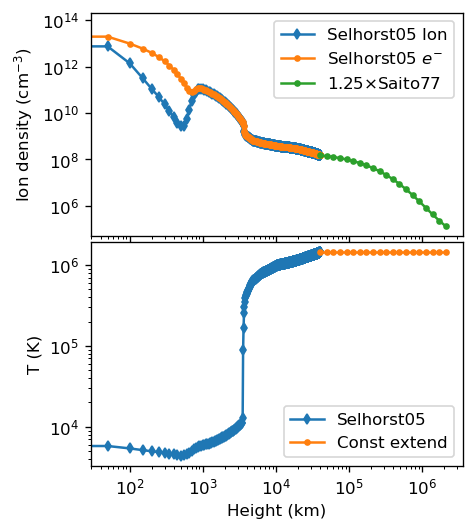

In [25]:
fig,(ax0, ax1) =plt.subplots(2,1,figsize=[4,5],dpi=120,sharex=True)
plt.subplots_adjust( hspace=0.025)

l1,=ax0.plot(height, ni_md,'d-',markersize=4)
ax0.set(xscale='log',yscale='log',
       ylabel=r'Ion density ($\rm cm^{-3}$)')
l2,=ax0.plot(height,ne_md,'.-')
l3,=ax0.plot(height_extend,ne_extend,'.-')
ax0.legend([l1,l2,l3],['Selhorst05 Ion','Selhorst05 $e^{-}$',r'1.25$\times$Saito77'])

l11,=ax1.plot(height, ta_md,'d-',markersize=4)
l12,=ax1.plot(height_extend, ta_extend,'.-')
ax1.legend([l11,l12],['Selhorst05','Const extend'])
ax1.set(xscale='log',yscale='log',xlabel='Height (km)',ylabel=r'T (K)')

fig.savefig('neTmodel.pdf',bbox_inches="tight")

In [26]:
# reverse for integral
height_all = np.flipud(np.concatenate([height,height_extend]))
ne_all = np.flipud(np.concatenate([ne_md,ne_extend]))
ni_all = np.flipud(np.concatenate([ni_md,ne_extend]))
ta_all = np.flipud(np.concatenate([ta_md,ta_extend]))

[Text(0.5, 0, 'Height'), Text(0, 0.5, 'T (K)')]

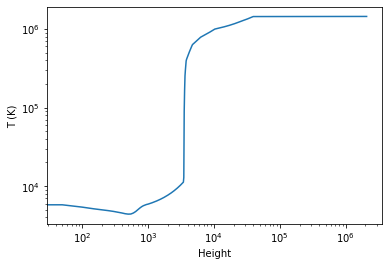

In [27]:
plt.loglog(height_all,ta_all)
plt.gca().set(xlabel='Height',ylabel='T (K)')

In [28]:
f0 = 20e9
lambda0=c/f0

In [11]:
z=1.178
g=gauntff.gauntff(f0,ta_all).ravel()
#kff=((2e-23)*z**2 * g * (lambda0)**(2)*ni_all*ne_all*ta_all**(-3/2.)*1e5) 
kff=3.7e8*ta_all**(-1/2.)*ne_all*ni_all*f0**(-3)*g*(1-np.exp(-hh*f0/kb/ta_all))*1e5 # opacity used in Selhorst et al. 2019

In [12]:
kff.shape

(820,)

In [13]:
# optical depth
# integral from corona to sun
tau = np.array([integrate.trapz(kff[0:idx],-height_all[0:idx])
       for idx in np.arange(height_all.shape[0]-1)+1])
Tb=integrate.trapz(ta_all[1:]*kff[1:]*np.exp(-tau),-height_all[1:])

[Text(0.5, 0, 'Height'), Text(0, 0.5, 'Optical depth $\\tau$')]

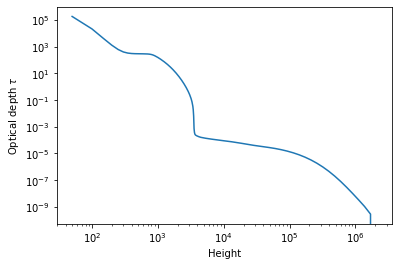

In [14]:
plt.loglog(height_all[0:-1],np.abs(tau))
plt.gca().set(xlabel='Height',ylabel=r'Optical depth $\tau$')

In [15]:
# calc spectrum

N_point=100
Tb_arr =np.zeros(N_point)
freq_arr = np.logspace(7,10.5,N_point)
for idx,freq in enumerate(freq_arr):
    lambda0=c/freq
    z=1.178
    g=gauntff.gauntff(freq,ta_all).ravel()
    kff=3.7e8*ta_all**(-1/2.)*ne_all*ni_all*freq**(-3)*g*(1-np.exp(-hh*freq/kb/ta_all))*1e5 # opacity used in Selhorst et al. 2019
    tau = np.array([integrate.trapz(kff[1:idx+1],-height_all[0:idx])
       for idx in np.arange(height_all.shape[0]-1)+1])
    Tb_arr[idx]=integrate.trapz(ta_all[1:]*kff[1:]*np.exp(-tau),-height_all[1:])
    

[Text(0.5, 0, 'Freq (MHz)'), Text(0, 0.5, '$T_b$ (K)')]

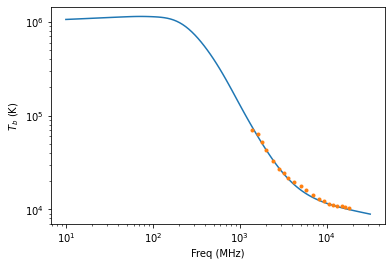

In [16]:
Z_obs=ascii.read('Z_obs.csv', format='basic', delimiter=',', guess=False) 
freq_obs,Tb_obs = (Z_obs['F']),(Z_obs['TBZ'])

plt.loglog(freq_arr/1e6,Tb_arr)
plt.plot(freq_obs*1e3,Tb_obs,'.')
plt.gca().set(xlabel='Freq (MHz)',ylabel=r'$T_b$ (K)')

In [17]:
model=astropy.table.Table()
model['f'] = freq_arr
model['tb'] = Tb_arr
astropy.io.ascii.write(model,'TbModel.csv', format='csv',overwrite=True) 

In [18]:
freq_multi_test=np.array([78.90014648, 78.11889648, 76.94702148, 74.21264648, 73.43139648,
       72.25952148, 71.47827148, 70.30639648, 69.52514648, 66.40014648,
       66.00952148, 64.44702148, 64.05639648, 61.71264648, 60.93139648,
       58.97827148, 58.58764648, 53.50952148, 52.53295898, 51.36108398,
       49.79858398, 48.62670898, 47.65014648, 46.28295898, 45.30639648,
       43.15795898, 42.18139648, 41.20483398, 40.22827148, 39.25170898,
       37.88452148, 36.90795898, 35.73608398, 34.75952148, 33.58764648,
       31.43920898, 30.46264648, 29.29077148, 28.50952148, 27.53295898,
       26.55639648, 25.57983398, 24.60327148, 23.62670898, 21.47827148])*1e6

Tb_arr =np.zeros(freq_multi_test.shape)

In [19]:
for idx,freq in enumerate(freq_multi_test):
    lambda0=c/freq
    z=1.178
    g=gauntff.gauntff(freq,ta_all).ravel()
    kff=3.7e8*ta_all**(-1/2.)*ne_all*ni_all*freq**(-3)*g*(1-np.exp(-hh*freq/kb/ta_all))*1e5 # opacity used in Selhorst et al. 2019
    tau = np.array([integrate.trapz(kff[1:idx+1],-height_all[0:idx])
       for idx in np.arange(height_all.shape[0]-1)+1])
    Tb_arr[idx]=integrate.trapz(ta_all[1:]*kff[1:]*np.exp(-tau),-height_all[1:])

In [20]:
Tb_obs = np.array([749776.0504771 , 746720.66255589, 748868.1654102 , 746785.81915949,
       726870.40525531, 746007.90478975, 730372.90813405, 733143.34270673,
       767456.18694056, 783011.93803178, 760257.49257317, 767428.02834947,
       755117.68384231, 764846.30628974, 695701.16967769, 671000.6945231 ,
       669852.98910083, 654376.53823424, 646221.7342441 , 637388.15501204,
       629795.94916016, 626467.28950489, 612573.03775993, 611142.55948678,
       601438.09786493, 586437.46436025, 571322.59968867, 563576.62455794,
       545751.40801799, 539720.41459282, 531388.02408461, 520122.65497096,
       502797.29158769, 497786.74664546, 482118.35159906, 458196.11392523,
       444998.88553956, 428879.67963519, 418620.57073567, 402251.0566743 ,
       371854.8353352 , 390422.9794727 , 386862.15428076, 383239.93479288,
       376906.8391606 ])

In [21]:
from scipy.optimize import curve_fit

In [22]:
def obj_func(f, a, b):
    return (1-a*f**b)

In [23]:
res_fit,err_fit=curve_fit(obj_func,freq_multi_test,(Tb_obs/Tb_arr))

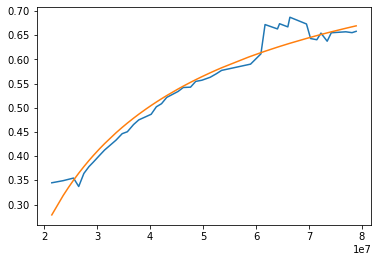

In [24]:
plt.plot(freq_multi_test,(Tb_obs/Tb_arr))
plt.plot(freq_multi_test,1-res_fit[0]*(freq_multi_test)**res_fit[1])

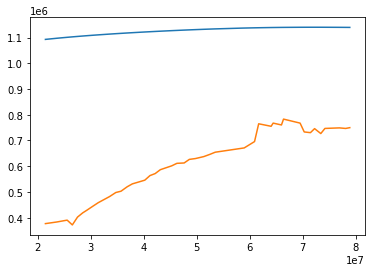

In [25]:
plt.plot(freq_multi_test,Tb_arr)
plt.plot(freq_multi_test,Tb_obs)

In [26]:
res_fit

array([ 1.80374599e+04, -5.99825969e-01])

In [28]:
np.sqrt(np.diag(err_fit))/2

array([2.96474232e+03, 9.40528739e-03])